In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import muse.supplier as spr
import muse.processor2 as pcr
import muse.model2 as mdl
import muse.trainer as trn
import muse.visualizer as vis

import warnings
warnings.filterwarnings("ignore")

In [2]:
### ===== Hyperparameters ===== ###

instrument = 'Piano'
filepath = "./../input/haydn/"
song_len = 200*1
stride = 200
device = trn.get_device()

seed_load = 592643464

In [3]:
### ===== Data Preprocessing ===== ###

all_midis, filenames = pcr.get_midis(filepath) # load all .midi files
Corpus, instru2corpus = pcr.get_notes_batch(all_midis) # extract all notes and sort by instrument
Corpus, fmap, rmap = pcr.get_map(Corpus) # get forward-map and reverse-map from corpus
instru2corpus = pcr.remove_short(instru2corpus) # remove songs that are too short

X_train_melody, X_val_melody, X_train_offset, X_val_offset = pcr.train_test_split(instru2corpus, instrument, fmap, song_len, stride,\
                                                                                  seed=seed_load, process='center')
X_train_melody, X_val_melody = pcr.batchify(X_train_melody), pcr.batchify(X_val_melody) # reshape and turn into tensor
X_train_offset, X_val_offset = pcr.batchify(X_train_offset), pcr.batchify(X_val_offset) # reshape and turn into tensor

classes = len(set(Corpus)) # get number of unique keys

## VAE-seperate

In [4]:
### ===== Load model ===== ###

mdl_name1 = 'vae4_melody'
model1 = mdl.cnn_varautoencoder(1, 1, 61, std=1.0)
model4, train_losses4, val_losses4, train_acc4, val_acc4, _, _ = trn.load_model('{}_CE'.format(mdl_name1), model1, device)

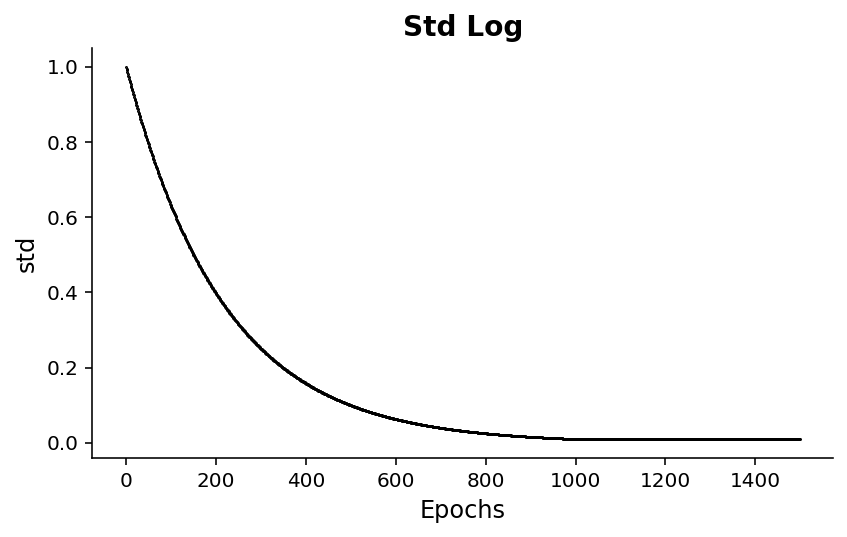

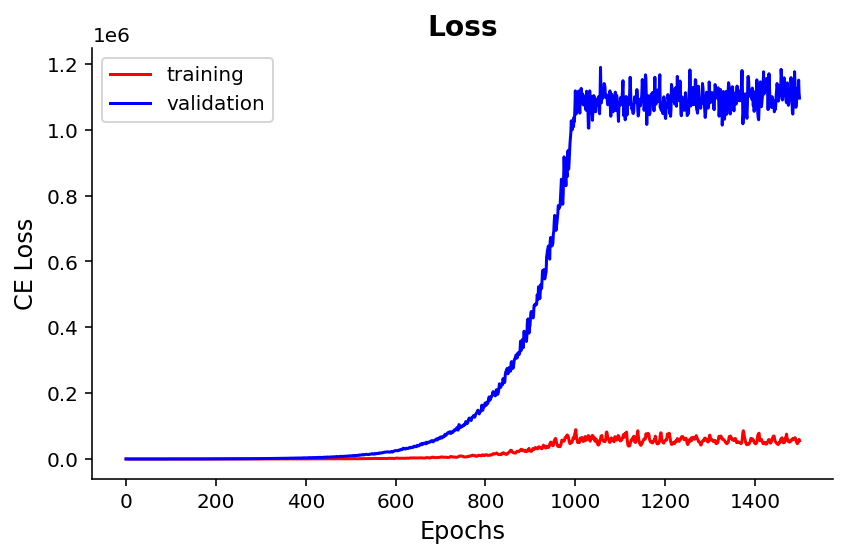

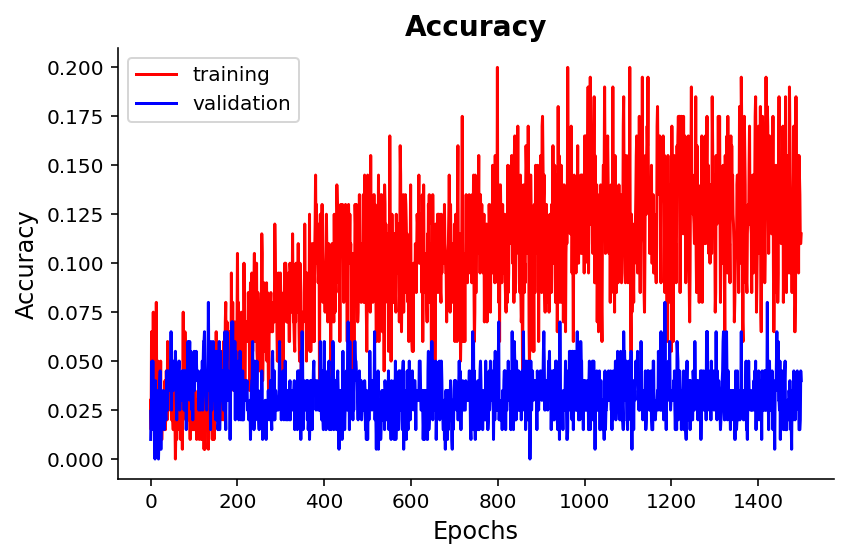

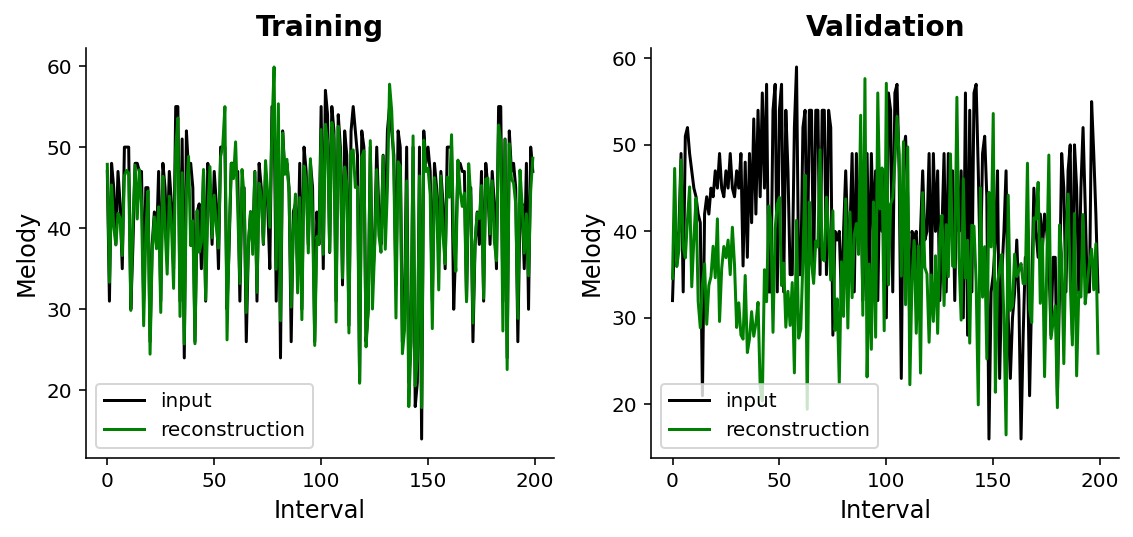

In [5]:
### ===== Training and validation ===== ###

stdlog = np.append(np.geomspace(1, 0.01, 1000), np.ones(500)*0.01)
vis.plot_stdlog(stdlog, './figures/{}_CE_stdlog.png'.format(mdl_name1), show=False)
vis.plot_train_val_loss(train_losses4, val_losses4, './figures/{}_CE_loss.png'.format(mdl_name1), ylabel='CE Loss', show=False)
vis.plot_train_val_loss(train_acc4, val_acc4, './figures/{}_CE_acc.png'.format(mdl_name1), ylabel='Accuracy', title='Accuracy', show=False)
_ = vis.plot_train_val_sample(model4, X_train_melody[0], X_val_melody[0], './figures/{}_CE_sample.png'.format(mdl_name1), show=False)

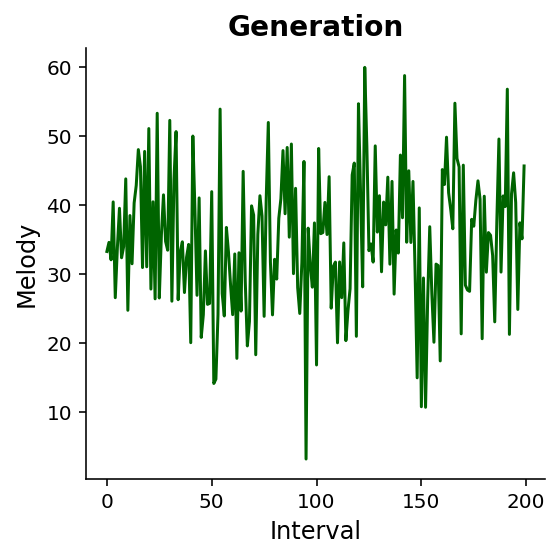

In [8]:
### ===== Generation ===== ###

mus = []
for song in X_train_melody:
    mu, logvar = model4.encoder(song)
    mus.append(mu.view(-1).detach().numpy())
    
mu_avg = np.mean(np.array(mus), axis=0)
cov_avg = np.cov(np.array(mus), rowvar=False)
new = pcr.gen_generation_vae(mu_avg, cov_avg, model4, rmap, fname='temp')
vis.plot_gen_sample(new.view(-1).detach().numpy(), './figures/{}_CE_gen.png'.format(mdl_name1))

NameError: name 'mus' is not defined

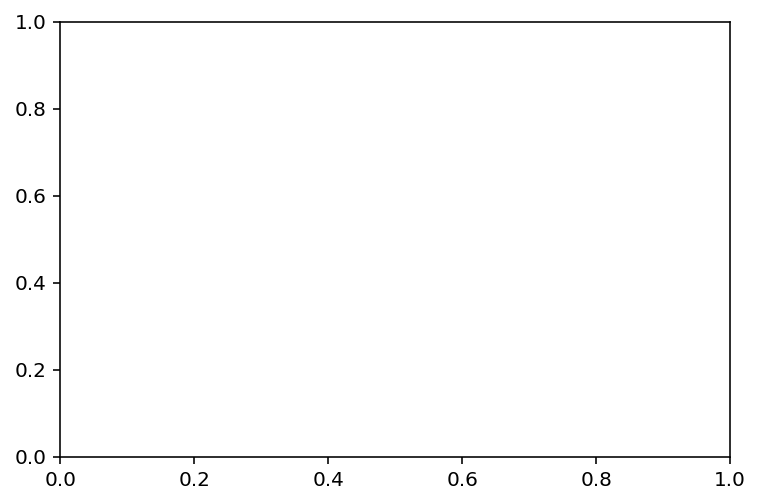

In [7]:
### ===== Latent space ===== ###

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.hist(np.array(mus)[:,2], color='b')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('\u03BC'); ax.set_ylabel('counts')
plt.savefig('./figures/{}_latent.png'.format(mdl_name1), dpi=300)

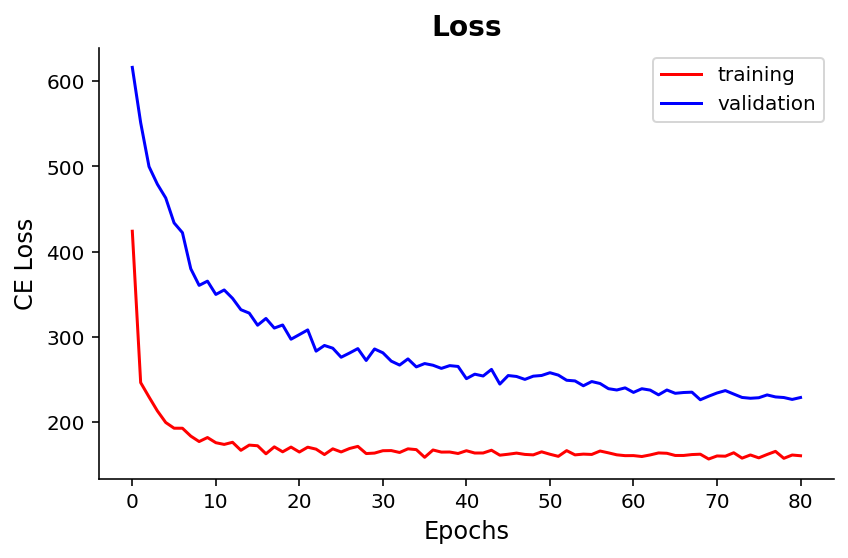

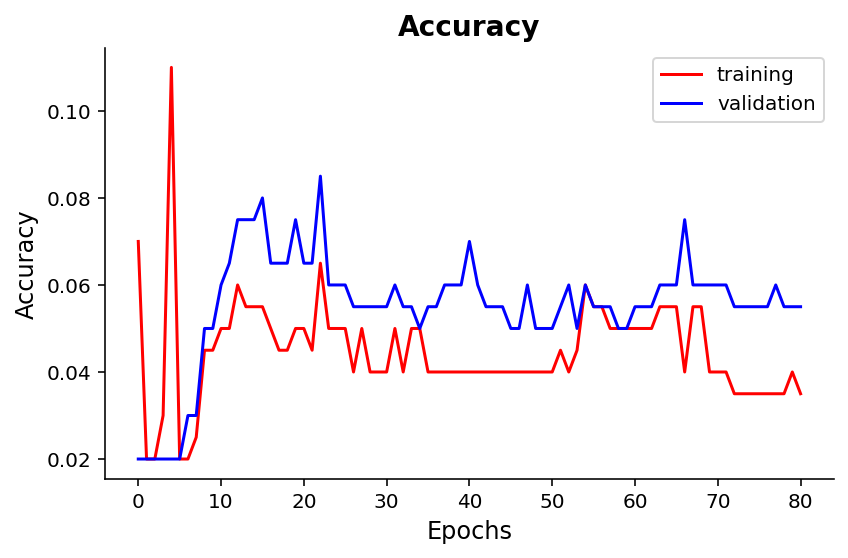

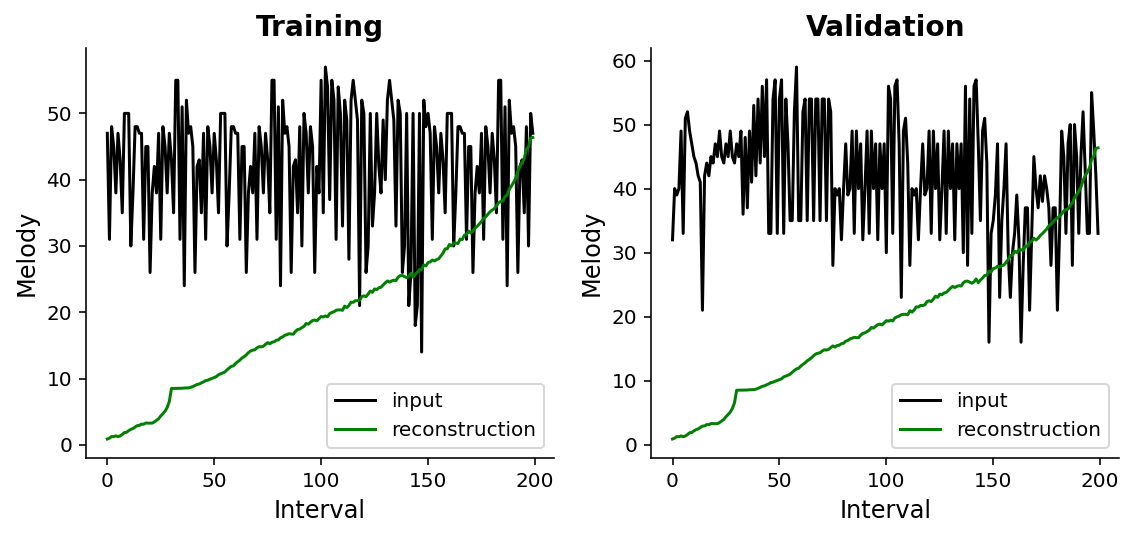

In [18]:
### ===== Load model for sep-offset ===== ###

mdl_name42 = 'vae43_offset_center'
model42 = mdl.cnn_varautoencoder(1, 1, 61, std=1.0)
model42, train_losses42, val_losses42, train_acc42, val_acc42, _, _ = trn.load_model('{}'.format(mdl_name42), model42, device)

vis.plot_train_val_loss(train_losses42, val_losses42, './figures/{}_loss.png'.format(mdl_name42), ylabel='CE Loss', show=False)
vis.plot_train_val_loss(train_acc42, val_acc42, './figures/{}_acc.png'.format(mdl_name42), ylabel='Accuracy', title='Accuracy', show=False)
_ = vis.plot_train_val_sample(model42, X_train_melody[0], X_val_melody[0], './figures/{}_sample.png'.format(mdl_name42), show=False)

In [19]:
### ===== Load model for failure case ===== ###

mdl_name46 = 'vae43_melody_CE'
model46 = mdl.cnn_varautoencoder(1, 1, 61, std=1.0)
model46, train_losses46, val_losses46, train_acc46, val_acc46, _, _ = trn.load_model('{}'.format(mdl_name46), model46, device)

vis.plot_train_val_loss(train_losses46, val_losses46, './figures/{}_loss.png'.format(mdl_name46), ylabel='CE Loss', show=False)
vis.plot_train_val_loss(train_acc46, val_acc46, './figures/{}_acc.png'.format(mdl_name46), ylabel='Accuracy', title='Accuracy', show=False)
_ = vis.plot_train_val_sample(model46, X_train_melody[0], X_val_melody[0], './figures/{}_sample.png'.format(mdl_name46), show=False)

FileNotFoundError: [Errno 2] No such file or directory: './models/vae43_melody_CE.pt'

In [26]:
### ===== Hyperparameters ===== ###

instrument = 'Piano'
filepath = "./../input/haydn/"
song_len = 200*4
stride = 200
seed_load = 21718471

import muse.processor as pcr

all_midis, filenames = pcr.get_midis(filepath) # load all .midi files
Corpus, instru2corpus = pcr.extract_notes_batch(all_midis) # extract all notes and sort by instrument
Corpus = pcr.remove_rare(Corpus, 0)[0] # remove notes that occur for less than $thre$ times
Corpus, fmap, rmap = pcr.get_map(Corpus) # get forward-map and reverse-map from corpus
instru2corpus = pcr.remove_short(instru2corpus) # remove songs that are too short
instru2corpus = pcr.upsample_batch(instru2corpus) # upsample notes according to multiples of duration
X_train, X_val, _, _ = pcr.train_test_split(instru2corpus, instrument, fmap, song_len, stride,\
                                                                                  seed=seed_load)
X_train, X_val = pcr.batchify(X_train), pcr.batchify(X_val) # reshape and turn into tensor
classes = len(set(Corpus)) # get number of unique keys

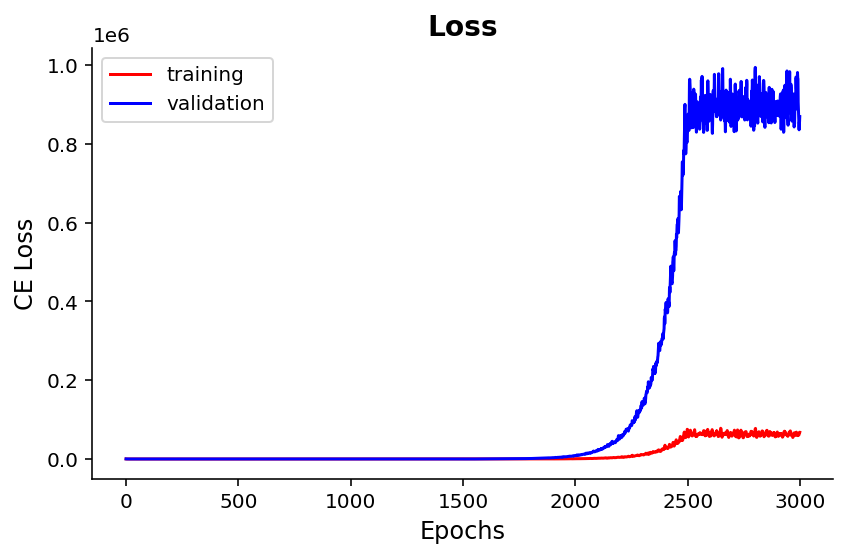

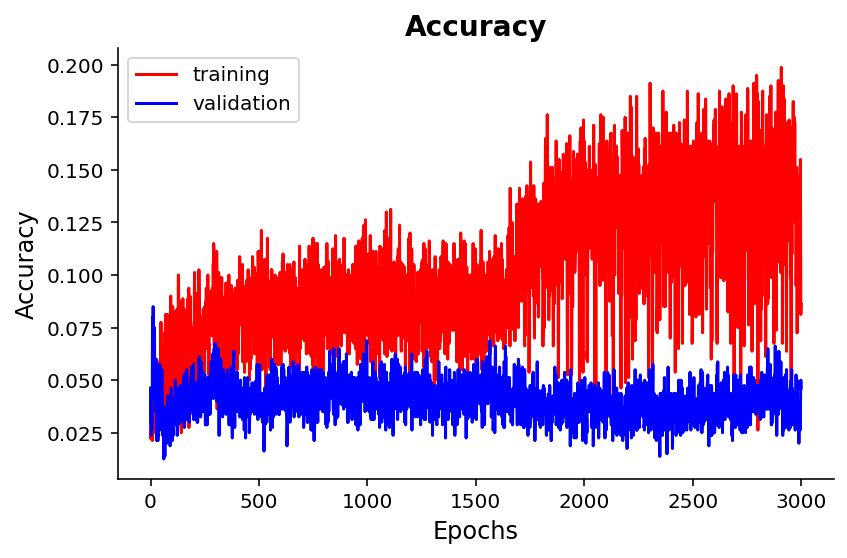

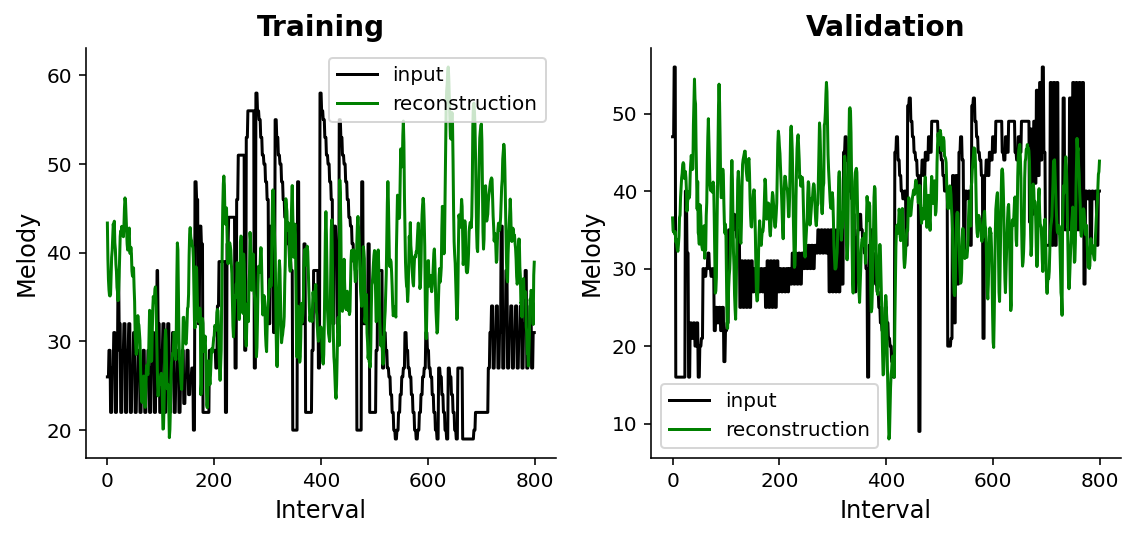

In [29]:
### ===== Load model for failure case ===== ###

mdl_name47 = 'vae3_melody_CE'
model47 = mdl.cnn_varautoencoder(1, 4, 61, std=1.0)
model47, train_losses47, val_losses47, train_acc47, val_acc47, _, _ = trn.load_model('{}'.format(mdl_name47), model47, device)

vis.plot_train_val_loss(train_losses47, val_losses47, './figures/{}_loss.png'.format(mdl_name47), ylabel='CE Loss', show=False)
vis.plot_train_val_loss(train_acc47, val_acc47, './figures/{}_acc.png'.format(mdl_name47), ylabel='Accuracy', title='Accuracy', show=False)
_ = vis.plot_train_val_sample(model47, X_train[0], X_val[0], './figures/{}_sample.png'.format(mdl_name47), show=False)

## AE-seperate

In [12]:
### ===== Load model ===== ###

model3 = mdl.cnn_autoencoder(1, 1, 61, std=1.0)
model3, train_losses3, val_losses3, train_acc3, val_acc3, _, _ = trn.load_model('ae', model3, device)

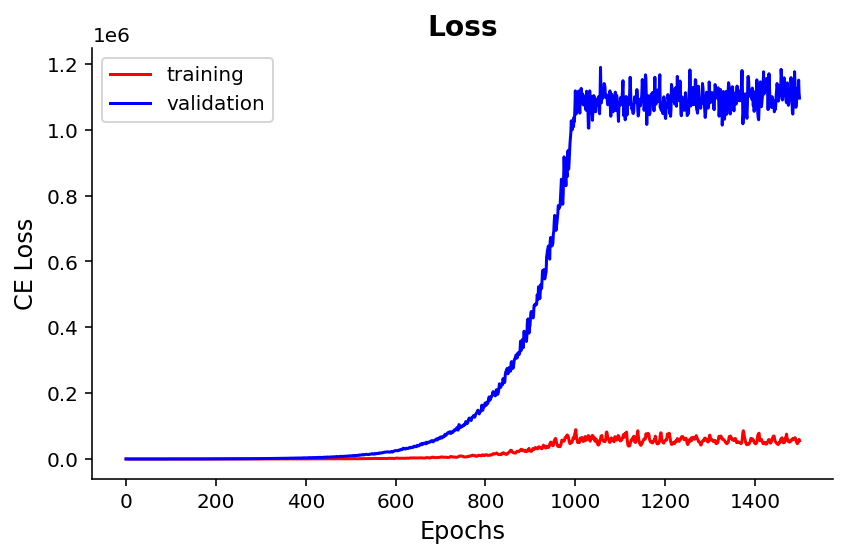

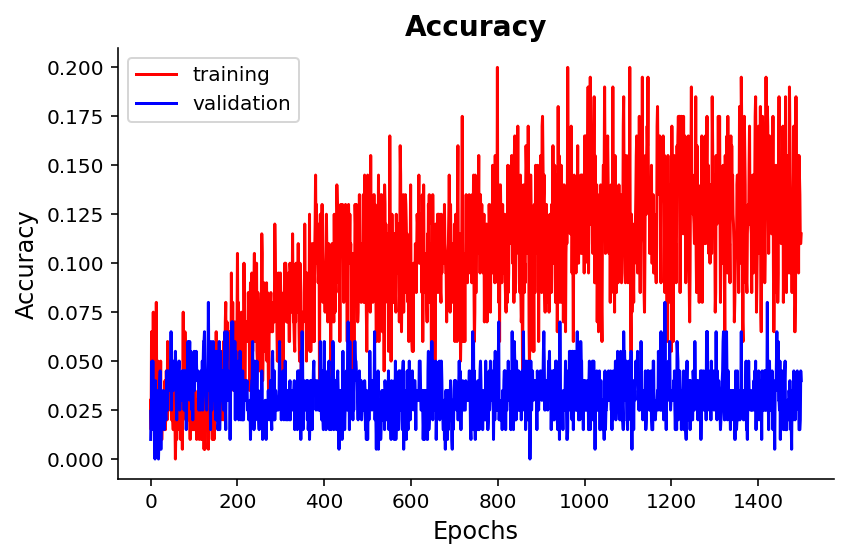

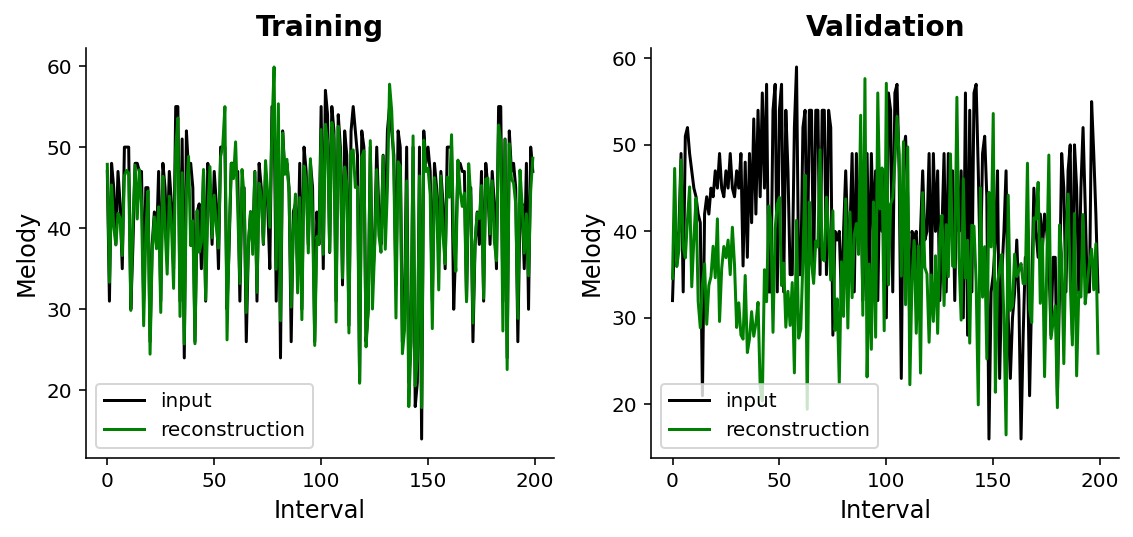

In [13]:
### ===== Training and validation ===== ###

mdl_name3 = 'ae'

vis.plot_train_val_loss(train_losses4, val_losses4, './figures/{}_loss.png'.format(mdl_name3), ylabel='CE Loss', show=False)
vis.plot_train_val_loss(train_acc4, val_acc4, './figures/{}_acc.png'.format(mdl_name3), ylabel='Accuracy', title='Accuracy', show=False)
_ = vis.plot_train_val_sample(model4, X_train_melody[0], X_val_melody[0], './figures/{}_sample.png'.format(mdl_name3), show=False)

## GAN

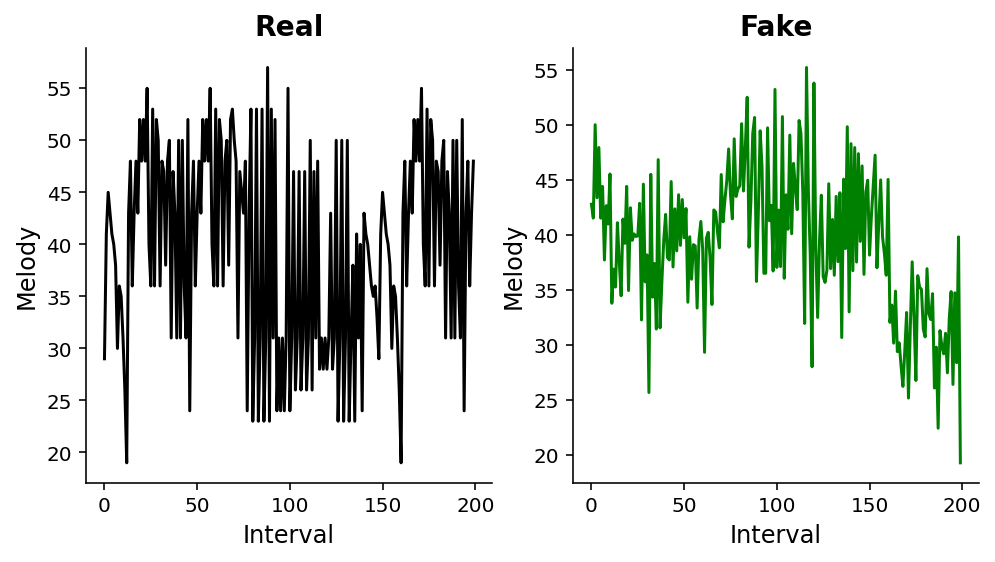

In [15]:
real = np.load('models/real.npy')
fake = np.load('models/fake.npy')

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(real, 'k')
ax2.plot(fake, 'g')

ax1.set_xlabel('Interval', fontsize=12); ax1.set_ylabel('Melody', fontsize=12)
ax1.set_title('Real', fontsize=14, fontweight='bold')
ax2.set_xlabel('Interval', fontsize=12); ax2.set_ylabel('Melody', fontsize=12)
ax2.set_title('Fake', fontsize=14, fontweight='bold')
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)

plt.savefig('figures/dcgan_sample.png', dpi=300)